# PID Tuning using GA

In [37]:
import numpy as np
import control
import matplotlib.pyplot as plt
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import PointCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

### Define fitness function

In [38]:
e=0.0000001 # to avoid division by zero
def fitness_function(t, error, criteria):
    # error=np.abs(1 - y)

    if criteria == 1:
        # ITAE (Integral of time multiplied absolute error)
        ITAE = np.trapz(t, error * t)
        fitness= 1/(ITAE+e)
    elif criteria == 2:
        # ITSE (Integral of time multiplied squared error)
        ITSE = np.trapz(t, t * error**2)
        fitness= 1/(ITSE+e)
    elif criteria == 3:
        # ITAE (Integral of time multiplied absolute error)
        IAE =  np.trapz(t, error)
        fitness= 1/(IAE+e)
    elif criteria == 4:
        # ITSE (Integral of time multiplied by squared error)
        ISE = np.trapz(t, error**2)
        fitness= 1/(ISE+e)
        
    return fitness

### Define the optimization problem for PID controller

$TF=\frac{K_ds^2+K_ps+K_i}{s^3+(K_d+10)s^2+(K_p+20)s+K_i}$

In [39]:
class PIDProblem(Problem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=1,
                         n_constr=0,
                         xl=0,
                         xu=100, vtype=float)    

    def _evaluate(self, X, out, *args, **kwargs):
        metric = np.zeros((X.shape[0], 1))
        for i, params in enumerate(X):
            Kp, Ki, Kd = params
            num = np.array([Kd,Kp,Ki])
            den = np.array([1,(Kd+10),(Kp+20),Ki])
            T = control.tf(num, den)
            t, y = control.step_response(T)
            error = 1 - y
            metric[i]=fitness_function(t, np.abs(error), 1)
        out["F"] = metric

### Define the solver and run for the PID problem

In [40]:
problem = PIDProblem()

algorithm = GA(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=PointCrossover(prob=0.8, n_points=2),
    mutation = PolynomialMutation(prob=0.3, repair=RoundingRepair()),
    eliminate_duplicates=True
)

res = minimize(problem, algorithm, ('n_gen', 100), seed=1, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 | -2.259704E+00 | -1.208426E+01
     2 |      100 | -5.545779E+00 | -1.824538E+01
     3 |      150 | -8.914928E+00 | -1.824538E+01
     4 |      200 | -1.268990E+01 | -1.952619E+01
     5 |      250 | -1.596634E+01 | -2.329394E+01
     6 |      300 | -1.995658E+01 | -2.642599E+01
     7 |      350 | -2.224631E+01 | -2.850232E+01
     8 |      400 | -2.438462E+01 | -2.850232E+01
     9 |      450 | -2.565199E+01 | -2.850232E+01
    10 |      500 | -2.649893E+01 | -2.850232E+01
    11 |      550 | -2.714609E+01 | -3.058097E+01
    12 |      600 | -2.745546E+01 | -3.058097E+01
    13 |      650 | -2.757816E+01 | -3.058097E+01
    14 |      700 | -2.769888E+01 | -3.058097E+01
    15 |      750 | -2.786319E+01 | -3.058097E+01
    16 |      800 | -2.791950E+01 | -3.058097E+01
    17 |      850 | -2.795884E+01 | -3.058097E+01
    18 |      900 | -2.798469E+01 | -3.058097E+01
    19 |      950 | -2.799219E+01 | -3.058097E+01


### Print the results

In [41]:
best_params = res.X
print("Optimal PID controller parameters:")
print("Kp =", best_params[0])
print("Ki =", best_params[1])
print("Kd =", best_params[2])

Optimal PID controller parameters:
Kp = 46
Ki = 100
Kd = 3


### Visualize the time response

T(s) = 
   3 s^2 + 46 s + 100
-------------------------
s^3 + 13 s^2 + 66 s + 100



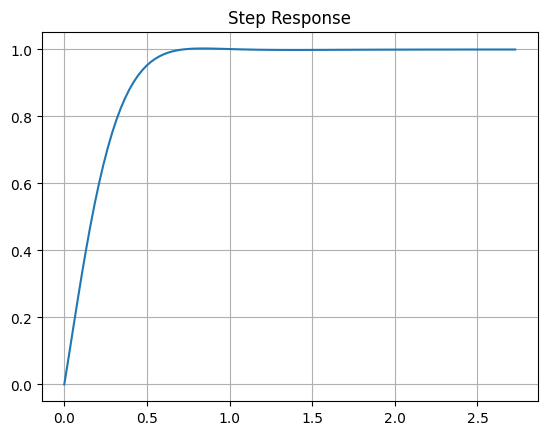

In [42]:
Kp = best_params[0]
Ki = best_params[1]
Kd = best_params[2]

# Close loo transfer function T:
num = np.array([Kd,Kp,Ki])
den = np.array([1,(Kd+10),(Kp+20),Ki])

T = control.tf(num, den)
print ('T(s) =', T)
t, y = control.step_response(T)
plt.plot(t,y)
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.grid()

### Check stability  [Optional]

<i>Asymptotically Stable System</i>
* All the poles ley in the left half plane
* All real parts of the pooles are negative

<i>Marginally Stable System</i>
* Poles coincide in the imaginary axis

<i>Unstable System</i>
* At least one pole lies in the right half plane (has real part greater than zero). 


p = [-5.2340361+3.47857199j -5.2340361-3.47857199j -2.5319278+0.j        ]


(array([-5.2340361+3.47857199j, -5.2340361-3.47857199j,
        -2.5319278+0.j        ]),
 array([-12.71091532+0.j,  -2.62241802+0.j]))

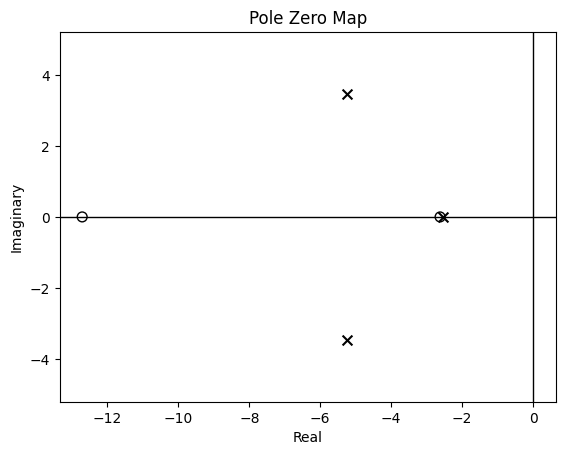

In [43]:
# Poles
p = control.pole(T)
print ('p =', p)

control.pzmap(T)